### Load data

In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv("/home/hoangbaoan1901/Documents/information-system_UET/sem5/prdan/Homeworks/week-3-btl/datasets/jrfm-2156907-cleaned.csv")

In [2]:
data['Date'] = pd.to_datetime(data['Date'])

#### Split train, test period

In [3]:
# Split data into 2 periods
start_day_p1 = pd.Timestamp(2015, 8, 7)
test_day_p1 = pd.Timestamp(2018, 4, 1)
end_day_p1 = pd.Timestamp(2018, 9, 30)

period1 = data[(data["Date"] >= start_day_p1) & (data["Date"] <= end_day_p1) ].reset_index(drop = True)
train_dataset_p1 = period1[period1["Date"] < test_day_p1].reset_index(drop = True)
test_dataset_p1 = period1[period1["Date"] >= test_day_p1].reset_index(drop = True)


start_day_p2 = pd.Timestamp(2018, 10, 1)
test_day_p2 = pd.Timestamp(2021, 10, 1)
end_day_p2 = pd.Timestamp(2022, 4, 1)

period2 = data[(data["Date"] >= start_day_p2) & (data["Date"] <= end_day_p2) ].reset_index(drop = True)
train_dataset_p2 = period2[period2["Date"] < test_day_p2].reset_index(drop = True)
test_dataset_p2 = period2[period2["Date"] >= test_day_p2].reset_index(drop = True)

train_dataset_p1 = train_dataset_p1.drop("Date", axis=1)
test_dataset_p1 = test_dataset_p1.drop("Date", axis=1)
train_dataset_p2 = train_dataset_p2.drop("Date", axis=1)
test_dataset_p2 = test_dataset_p2.drop("Date", axis=1)


print(period1.shape, period2.shape)

(1151, 48) (1279, 48)


### List Evaluation metrics

In [4]:
# Metrics
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import accuracy_score

def directional_accuracy(y_true, y_pred):
	y_test_da = np.array(y_true)
	y_pred_0 = y_pred[1:] - y_test_da[:-1]
	y_test_0 = y_true[1:] - y_test_da[:-1]
	DA = (y_pred_0<0) == (y_test_0<0)
	return np.mean(DA)*100

### Function to create X and y

In [5]:
# Function to create X and y
def create_train_test(train_dataset, test_dataset):
	X_train = train_dataset[:-1]
	Y_train = train_dataset["BTC_Close"][1:]
	X_test = test_dataset[:-1]
	Y_test = test_dataset["BTC_Close"][1:]
	return X_train, Y_train, X_test, Y_test

X_train_p1, Y_train_p1, X_test_p1, Y_test_p1 = create_train_test(train_dataset_p1, test_dataset_p1)
X_train_p2, Y_train_p2, X_test_p2, Y_test_p2 = create_train_test(train_dataset_p2, test_dataset_p2)

# Scale data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_p1 = scaler.fit_transform(X_train_p1)
X_test_p1 = scaler.transform(X_test_p1)
X_train_p2 = scaler.fit_transform(X_train_p2)
X_test_p2 = scaler.transform(X_test_p2)
Y_train_p1 = scaler.fit_transform(Y_train_p1.values.reshape(-1, 1))
Y_test_p1 = scaler.transform(Y_test_p1.values.reshape(-1, 1))
Y_train_p2 = scaler.fit_transform(Y_train_p2.values.reshape(-1, 1))
Y_test_p2 = scaler.transform(Y_test_p2.values.reshape(-1, 1))

### Create model

#### Create ParamGrid

In [6]:
from sklearn.model_selection import ParameterGrid
from sklearn.svm import SVR

params = {
	'C': [0.1, 1, 10, 100],
	'epsilon': [0.01, 0.1, 0.2, 0.5],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4, 5],
}

param_grid = list(ParameterGrid(params))
print(len(param_grid))
print(param_grid[0])
model = SVR(kernel='linear')


256
{'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'linear'}


In [7]:
import gc
final_model = None
best_score = 1000000000

for param in param_grid:
    model.set_params(**param)
    model.fit(X_train_p2, Y_train_p2)
    Y_pred = model.predict(X_test_p2)
    score = root_mean_squared_error(Y_test_p2, Y_pred)
    if score < best_score:
        best_score = score
        final_model = model
        best_param = param
    gc.collect()
    print(param, score)

{'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'linear'} 0.03226890765076646


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'poly'} 0.062163322867481934
{'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13169062829350708


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'sigmoid'} 1.855035462794252
{'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'linear'} 0.06485069152993304
{'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'} 0.10727156856864961


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'rbf'} 0.13374108726568162


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'sigmoid'} 1.7728256305372914
{'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'kernel': 'poly'} 0.10507359435508809


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'kernel': 'rbf'} 0.17845498688040834
{'C': 0.1, 'degree': 2, 'epsilon': 0.2, 'kernel': 'sigmoid'} 1.6495426848847774


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 2, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 0.1, 'degree': 2, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 0.1, 'degree': 2, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 2, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074
{'C': 0.1, 'degree': 3, 'epsilon': 0.01, 'kernel': 'linear'} 0.03226890765076646


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 3, 'epsilon': 0.01, 'kernel': 'poly'} 0.13167652482352557
{'C': 0.1, 'degree': 3, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13169062829350708


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 3, 'epsilon': 0.01, 'kernel': 'sigmoid'} 1.855035462794252
{'C': 0.1, 'degree': 3, 'epsilon': 0.1, 'kernel': 'linear'} 0.06485069152993304
{'C': 0.1, 'degree': 3, 'epsilon': 0.1, 'kernel': 'poly'} 0.19299205090049


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 3, 'epsilon': 0.1, 'kernel': 'rbf'} 0.13374108726568162
{'C': 0.1, 'degree': 3, 'epsilon': 0.1, 'kernel': 'sigmoid'} 1.7728256305372914


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 0.1, 'degree': 3, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 0.1, 'degree': 3, 'epsilon': 0.2, 'kernel': 'poly'} 0.1188457079274804
{'C': 0.1, 'degree': 3, 'epsilon': 0.2, 'kernel': 'rbf'} 0.17845498688040834


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 3, 'epsilon': 0.2, 'kernel': 'sigmoid'} 1.6495426848847774
{'C': 0.1, 'degree': 3, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 0.1, 'degree': 3, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 0.1, 'degree': 3, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 0.1, 'degree': 3, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074
{'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'kernel': 'linear'} 0.03226890765076646


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'kernel': 'poly'} 0.18119565337492977
{'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13169062829350708


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 4, 'epsilon': 0.01, 'kernel': 'sigmoid'} 1.855035462794252
{'C': 0.1, 'degree': 4, 'epsilon': 0.1, 'kernel': 'linear'} 0.06485069152993304
{'C': 0.1, 'degree': 4, 'epsilon': 0.1, 'kernel': 'poly'} 0.2672860150203561


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 4, 'epsilon': 0.1, 'kernel': 'rbf'} 0.13374108726568162
{'C': 0.1, 'degree': 4, 'epsilon': 0.1, 'kernel': 'sigmoid'} 1.7728256305372914


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'kernel': 'poly'} 0.14811237817281514
{'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'kernel': 'rbf'} 0.17845498688040834


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 4, 'epsilon': 0.2, 'kernel': 'sigmoid'} 1.6495426848847774
{'C': 0.1, 'degree': 4, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 0.1, 'degree': 4, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 0.1, 'degree': 4, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 0.1, 'degree': 4, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074
{'C': 0.1, 'degree': 5, 'epsilon': 0.01, 'kernel': 'linear'} 0.03226890765076646
{'C': 0.1, 'degree': 5, 'epsilon': 0.01, 'kernel': 'poly'} 0.12836087151767533
{'C': 0.1, 'degree': 5, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13169062829350708


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 5, 'epsilon': 0.01, 'kernel': 'sigmoid'} 1.855035462794252
{'C': 0.1, 'degree': 5, 'epsilon': 0.1, 'kernel': 'linear'} 0.06485069152993304
{'C': 0.1, 'degree': 5, 'epsilon': 0.1, 'kernel': 'poly'} 0.3762707802881136


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 5, 'epsilon': 0.1, 'kernel': 'rbf'} 0.13374108726568162
{'C': 0.1, 'degree': 5, 'epsilon': 0.1, 'kernel': 'sigmoid'} 1.7728256305372914


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 5, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 0.1, 'degree': 5, 'epsilon': 0.2, 'kernel': 'poly'} 0.20162716584478063
{'C': 0.1, 'degree': 5, 'epsilon': 0.2, 'kernel': 'rbf'} 0.17845498688040834


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 0.1, 'degree': 5, 'epsilon': 0.2, 'kernel': 'sigmoid'} 1.6495426848847774
{'C': 0.1, 'degree': 5, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 0.1, 'degree': 5, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 0.1, 'degree': 5, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 0.1, 'degree': 5, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074
{'C': 1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'linear'} 0.03029898832257673


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'poly'} 0.08641949083417393
{'C': 1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13906679251676166


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 2, 'epsilon': 0.01, 'kernel': 'sigmoid'} 12.643873392084723
{'C': 1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'} 0.10727156856864961
{'C': 1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'sigmoid'} 12.650721901962362
{'C': 1, 'degree': 2, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 1, 'degree': 2, 'epsilon': 0.2, 'kernel': 'poly'} 0.10507359435508809
{'C': 1, 'degree': 2, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 2, 'epsilon': 0.2, 'kernel': 'sigmoid'} 12.618077801814632
{'C': 1, 'degree': 2, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 1, 'degree': 2, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 1, 'degree': 2, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 2, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074
{'C': 1, 'degree': 3, 'epsilon': 0.01, 'kernel': 'linear'} 0.03029898832257673


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 3, 'epsilon': 0.01, 'kernel': 'poly'} 0.13118304485952187
{'C': 1, 'degree': 3, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13906679251676166


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 3, 'epsilon': 0.01, 'kernel': 'sigmoid'} 12.643873392084723
{'C': 1, 'degree': 3, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 1, 'degree': 3, 'epsilon': 0.1, 'kernel': 'poly'} 0.19299205090049
{'C': 1, 'degree': 3, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 3, 'epsilon': 0.1, 'kernel': 'sigmoid'} 12.650721901962362
{'C': 1, 'degree': 3, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 1, 'degree': 3, 'epsilon': 0.2, 'kernel': 'poly'} 0.1188457079274804
{'C': 1, 'degree': 3, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 3, 'epsilon': 0.2, 'kernel': 'sigmoid'} 12.618077801814632
{'C': 1, 'degree': 3, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 1, 'degree': 3, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 1, 'degree': 3, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 3, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 4, 'epsilon': 0.01, 'kernel': 'linear'} 0.03029898832257673


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 4, 'epsilon': 0.01, 'kernel': 'poly'} 0.11799825976986193
{'C': 1, 'degree': 4, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13906679251676166


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 4, 'epsilon': 0.01, 'kernel': 'sigmoid'} 12.643873392084723
{'C': 1, 'degree': 4, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 1, 'degree': 4, 'epsilon': 0.1, 'kernel': 'poly'} 0.2672860150203561
{'C': 1, 'degree': 4, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 4, 'epsilon': 0.1, 'kernel': 'sigmoid'} 12.650721901962362
{'C': 1, 'degree': 4, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 1, 'degree': 4, 'epsilon': 0.2, 'kernel': 'poly'} 0.14811237817281514
{'C': 1, 'degree': 4, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 4, 'epsilon': 0.2, 'kernel': 'sigmoid'} 12.618077801814632
{'C': 1, 'degree': 4, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 1, 'degree': 4, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 1, 'degree': 4, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 4, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074
{'C': 1, 'degree': 5, 'epsilon': 0.01, 'kernel': 'linear'} 0.03029898832257673


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 5, 'epsilon': 0.01, 'kernel': 'poly'} 0.12679029374574888
{'C': 1, 'degree': 5, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13906679251676166


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 5, 'epsilon': 0.01, 'kernel': 'sigmoid'} 12.643873392084723
{'C': 1, 'degree': 5, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 1, 'degree': 5, 'epsilon': 0.1, 'kernel': 'poly'} 0.3762707802881136


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 5, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 1, 'degree': 5, 'epsilon': 0.1, 'kernel': 'sigmoid'} 12.650721901962362
{'C': 1, 'degree': 5, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 1, 'degree': 5, 'epsilon': 0.2, 'kernel': 'poly'} 0.20162716584478063
{'C': 1, 'degree': 5, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 5, 'epsilon': 0.2, 'kernel': 'sigmoid'} 12.618077801814632
{'C': 1, 'degree': 5, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 1, 'degree': 5, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 1, 'degree': 5, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 1, 'degree': 5, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 2, 'epsilon': 0.01, 'kernel': 'linear'} 0.029397799374361846


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 2, 'epsilon': 0.01, 'kernel': 'poly'} 0.09370949864814677
{'C': 10, 'degree': 2, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13201729039794682


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 2, 'epsilon': 0.01, 'kernel': 'sigmoid'} 120.04537491068507
{'C': 10, 'degree': 2, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 10, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'} 0.10727156856864961
{'C': 10, 'degree': 2, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 10, 'degree': 2, 'epsilon': 0.1, 'kernel': 'sigmoid'} 120.13992770921125
{'C': 10, 'degree': 2, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 10, 'degree': 2, 'epsilon': 0.2, 'kernel': 'poly'} 0.10507359435508809
{'C': 10, 'degree': 2, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 10, 'degree': 2, 'epsilon': 0.2, 'kernel': 'sigmoid'} 120.21002147955991
{'C': 10, 'degree': 2, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 10, 'degree': 2, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 10, 'degree': 2, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 10, 'degree': 2, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 3, 'epsilon': 0.01, 'kernel': 'linear'} 0.029397799374361846


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 3, 'epsilon': 0.01, 'kernel': 'poly'} 0.10966226299594126
{'C': 10, 'degree': 3, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13201729039794682


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 3, 'epsilon': 0.01, 'kernel': 'sigmoid'} 120.04537491068507
{'C': 10, 'degree': 3, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 10, 'degree': 3, 'epsilon': 0.1, 'kernel': 'poly'} 0.19299205090049
{'C': 10, 'degree': 3, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 10, 'degree': 3, 'epsilon': 0.1, 'kernel': 'sigmoid'} 120.13992770921125
{'C': 10, 'degree': 3, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 10, 'degree': 3, 'epsilon': 0.2, 'kernel': 'poly'} 0.1188457079274804


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 3, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 3, 'epsilon': 0.2, 'kernel': 'sigmoid'} 120.21002147955991
{'C': 10, 'degree': 3, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 10, 'degree': 3, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 3, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074
{'C': 10, 'degree': 3, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 4, 'epsilon': 0.01, 'kernel': 'linear'} 0.029397799374361846


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 4, 'epsilon': 0.01, 'kernel': 'poly'} 0.11128464870371249
{'C': 10, 'degree': 4, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13201729039794682


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 4, 'epsilon': 0.01, 'kernel': 'sigmoid'} 120.04537491068507
{'C': 10, 'degree': 4, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 10, 'degree': 4, 'epsilon': 0.1, 'kernel': 'poly'} 0.2672860150203561


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 4, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 4, 'epsilon': 0.1, 'kernel': 'sigmoid'} 120.13992770921125
{'C': 10, 'degree': 4, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 10, 'degree': 4, 'epsilon': 0.2, 'kernel': 'poly'} 0.14811237817281514


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 4, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 4, 'epsilon': 0.2, 'kernel': 'sigmoid'} 120.21002147955991
{'C': 10, 'degree': 4, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 10, 'degree': 4, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 4, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074
{'C': 10, 'degree': 4, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 5, 'epsilon': 0.01, 'kernel': 'linear'} 0.029397799374361846


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 5, 'epsilon': 0.01, 'kernel': 'poly'} 0.12679029374574888


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 5, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13201729039794682


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 10, 'degree': 5, 'epsilon': 0.01, 'kernel': 'sigmoid'} 120.04537491068507
{'C': 10, 'degree': 5, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 10, 'degree': 5, 'epsilon': 0.1, 'kernel': 'poly'} 0.3762707802881136
{'C': 10, 'degree': 5, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 10, 'degree': 5, 'epsilon': 0.1, 'kernel': 'sigmoid'} 120.13992770921125
{'C': 10, 'degree': 5, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 10, 'degree': 5, 'epsilon': 0.2, 'kernel': 'poly'} 0.20162716584478063
{'C': 10, 'degree': 5, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 10, 'degree': 5, 'epsilon': 0.2, 'kernel': 'sigmoid'} 120.21002147955991
{'C': 10, 'degree': 5, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 10, 'degree': 5, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 10, 'degree': 5, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 10, 'degree': 5, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 2, 'epsilon': 0.01, 'kernel': 'linear'} 0.029505367733595418


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 2, 'epsilon': 0.01, 'kernel': 'poly'} 0.10044519414612754
{'C': 100, 'degree': 2, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13291957303320484


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 2, 'epsilon': 0.01, 'kernel': 'sigmoid'} 1194.0268530128872
{'C': 100, 'degree': 2, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 100, 'degree': 2, 'epsilon': 0.1, 'kernel': 'poly'} 0.10727156856864961
{'C': 100, 'degree': 2, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 2, 'epsilon': 0.1, 'kernel': 'sigmoid'} 1194.2884435795293
{'C': 100, 'degree': 2, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 100, 'degree': 2, 'epsilon': 0.2, 'kernel': 'poly'} 0.10507359435508809
{'C': 100, 'degree': 2, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 2, 'epsilon': 0.2, 'kernel': 'sigmoid'} 1193.823779373507
{'C': 100, 'degree': 2, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 100, 'degree': 2, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 100, 'degree': 2, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 2, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074
{'C': 100, 'degree': 3, 'epsilon': 0.01, 'kernel': 'linear'} 0.029505367733595418


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 3, 'epsilon': 0.01, 'kernel': 'poly'} 0.10351022838998117
{'C': 100, 'degree': 3, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13291957303320484


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 3, 'epsilon': 0.01, 'kernel': 'sigmoid'} 1194.0268530128872
{'C': 100, 'degree': 3, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 100, 'degree': 3, 'epsilon': 0.1, 'kernel': 'poly'} 0.19299205090049
{'C': 100, 'degree': 3, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 3, 'epsilon': 0.1, 'kernel': 'sigmoid'} 1194.2884435795293
{'C': 100, 'degree': 3, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 100, 'degree': 3, 'epsilon': 0.2, 'kernel': 'poly'} 0.1188457079274804
{'C': 100, 'degree': 3, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 3, 'epsilon': 0.2, 'kernel': 'sigmoid'} 1193.823779373507
{'C': 100, 'degree': 3, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 100, 'degree': 3, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 100, 'degree': 3, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 3, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 4, 'epsilon': 0.01, 'kernel': 'linear'} 0.029505367733595418


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 4, 'epsilon': 0.01, 'kernel': 'poly'} 0.11128464870371249
{'C': 100, 'degree': 4, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13291957303320484


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 4, 'epsilon': 0.01, 'kernel': 'sigmoid'} 1194.0268530128872
{'C': 100, 'degree': 4, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 100, 'degree': 4, 'epsilon': 0.1, 'kernel': 'poly'} 0.2672860150203561
{'C': 100, 'degree': 4, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 4, 'epsilon': 0.1, 'kernel': 'sigmoid'} 1194.2884435795293
{'C': 100, 'degree': 4, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 100, 'degree': 4, 'epsilon': 0.2, 'kernel': 'poly'} 0.14811237817281514
{'C': 100, 'degree': 4, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 4, 'epsilon': 0.2, 'kernel': 'sigmoid'} 1193.823779373507
{'C': 100, 'degree': 4, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 100, 'degree': 4, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 100, 'degree': 4, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 4, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 5, 'epsilon': 0.01, 'kernel': 'linear'} 0.029505367733595418


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 5, 'epsilon': 0.01, 'kernel': 'poly'} 0.12679029374574888
{'C': 100, 'degree': 5, 'epsilon': 0.01, 'kernel': 'rbf'} 0.13291957303320484


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'C': 100, 'degree': 5, 'epsilon': 0.01, 'kernel': 'sigmoid'} 1194.0268530128872
{'C': 100, 'degree': 5, 'epsilon': 0.1, 'kernel': 'linear'} 0.06509079947248915
{'C': 100, 'degree': 5, 'epsilon': 0.1, 'kernel': 'poly'} 0.3762707802881136
{'C': 100, 'degree': 5, 'epsilon': 0.1, 'kernel': 'rbf'} 0.1311273569816113


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 5, 'epsilon': 0.1, 'kernel': 'sigmoid'} 1194.2884435795293
{'C': 100, 'degree': 5, 'epsilon': 0.2, 'kernel': 'linear'} 0.09375700005317189
{'C': 100, 'degree': 5, 'epsilon': 0.2, 'kernel': 'poly'} 0.20162716584478063
{'C': 100, 'degree': 5, 'epsilon': 0.2, 'kernel': 'rbf'} 0.1743694193247108


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 5, 'epsilon': 0.2, 'kernel': 'sigmoid'} 1193.823779373507
{'C': 100, 'degree': 5, 'epsilon': 0.5, 'kernel': 'linear'} 0.2926233598162074
{'C': 100, 'degree': 5, 'epsilon': 0.5, 'kernel': 'poly'} 0.2926233598162074
{'C': 100, 'degree': 5, 'epsilon': 0.5, 'kernel': 'rbf'} 0.2926233598162074


/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hoangbaoan1901/anaconda3/envs/tf-env/lib/python3.12/site-packages/sklearn/utils/validation.py:1339: DataConve

{'C': 100, 'degree': 5, 'epsilon': 0.5, 'kernel': 'sigmoid'} 0.2926233598162074


{'C': 10, 'degree': 2, 'epsilon': 0.01, 'kernel': 'linear'} 0.029397799374361846
R2 score:  -3.026618009737235
directional_accuracy:  49.171270718232044


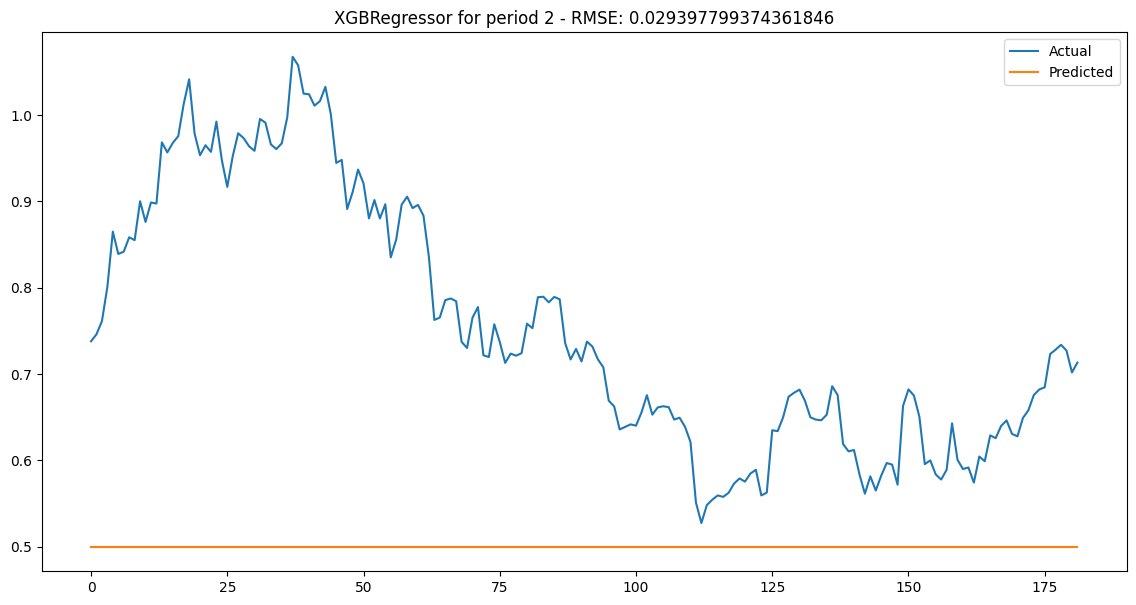

In [9]:
print(best_param, best_score)
# plot prediction
import matplotlib.pyplot as plt
plt.figure(figsize=(14,7))
plt.title(f"XGBRegressor for period 2 - RMSE: {best_score}")
Y_pred = final_model.predict(X_test_p2)
print("R2 score: ", r2_score(Y_test_p2, Y_pred))
print("directional_accuracy: ", directional_accuracy(Y_test_p2, Y_pred))
plt.plot(Y_test_p2, label="Actual")
plt.plot(Y_pred, label="Predicted")
plt.legend()
plt.show()
